In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

from dataclasses import dataclass
from typing import List, Tuple, Dict, Union, Any, cast, Optional

# Let's build the skeleton of the llama model

In [ ]:
@dataclass
class ModelArgs:
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32
    n_kv_heads: Optional[int] = None
    vocab_size: int = -1 # Later set in the build method
    multiple_of: int = 256
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    # Needed for KV cache
    max_batch_size: int = 32
    max_seq_len: int = 2048

    device: str = None

In [ ]:
class Transformer(nn.Module):

    def __init__(self, args: ModelArgs):
        super().__init__()

        assert args.vocab_size != -1, "Vocab size must be set"

        self.args = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        self.tok_embeddings = nn.Embedding(self.vocab_size, args.dim)

        self.layers = nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(EncoderBlock(args))

        self.norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.output = nn.Linear(args.dim, self.vocab_size, bias=False)

        self.freqs_complex = precompute_theta_pos_frequencies(self.args.dim // self.args.n_heads, self.args.max_seq_len * 2, device=self.args.device)

    def forward(self, tokens: torch.Tensor, start_pos: int):
        # (B, Seq_Len)
        batch_size, seq_len = tokens.shape
        assert seq_len == 1, "Only one token at a time can be processed"

        # (B, Seq_Len) -> (B, Seq_Len, Dim)
        h = self.tok_embeddings(tokens)

        # Retrieve the pairs (m, theta) corresponding to the positions [start_pos, start_pos + seq_len]
        freqs_complex = self.freqs_complex[start_pos:start_pos + seq_len]
        
        # Consecutively apply all the encoder layers
        for layer in self.layers:
            h = layer(h, start_pos, freqs_complex)
        h = self.norm(h)
        output = self.output(h).float()
        return output

## Rotary Embedding

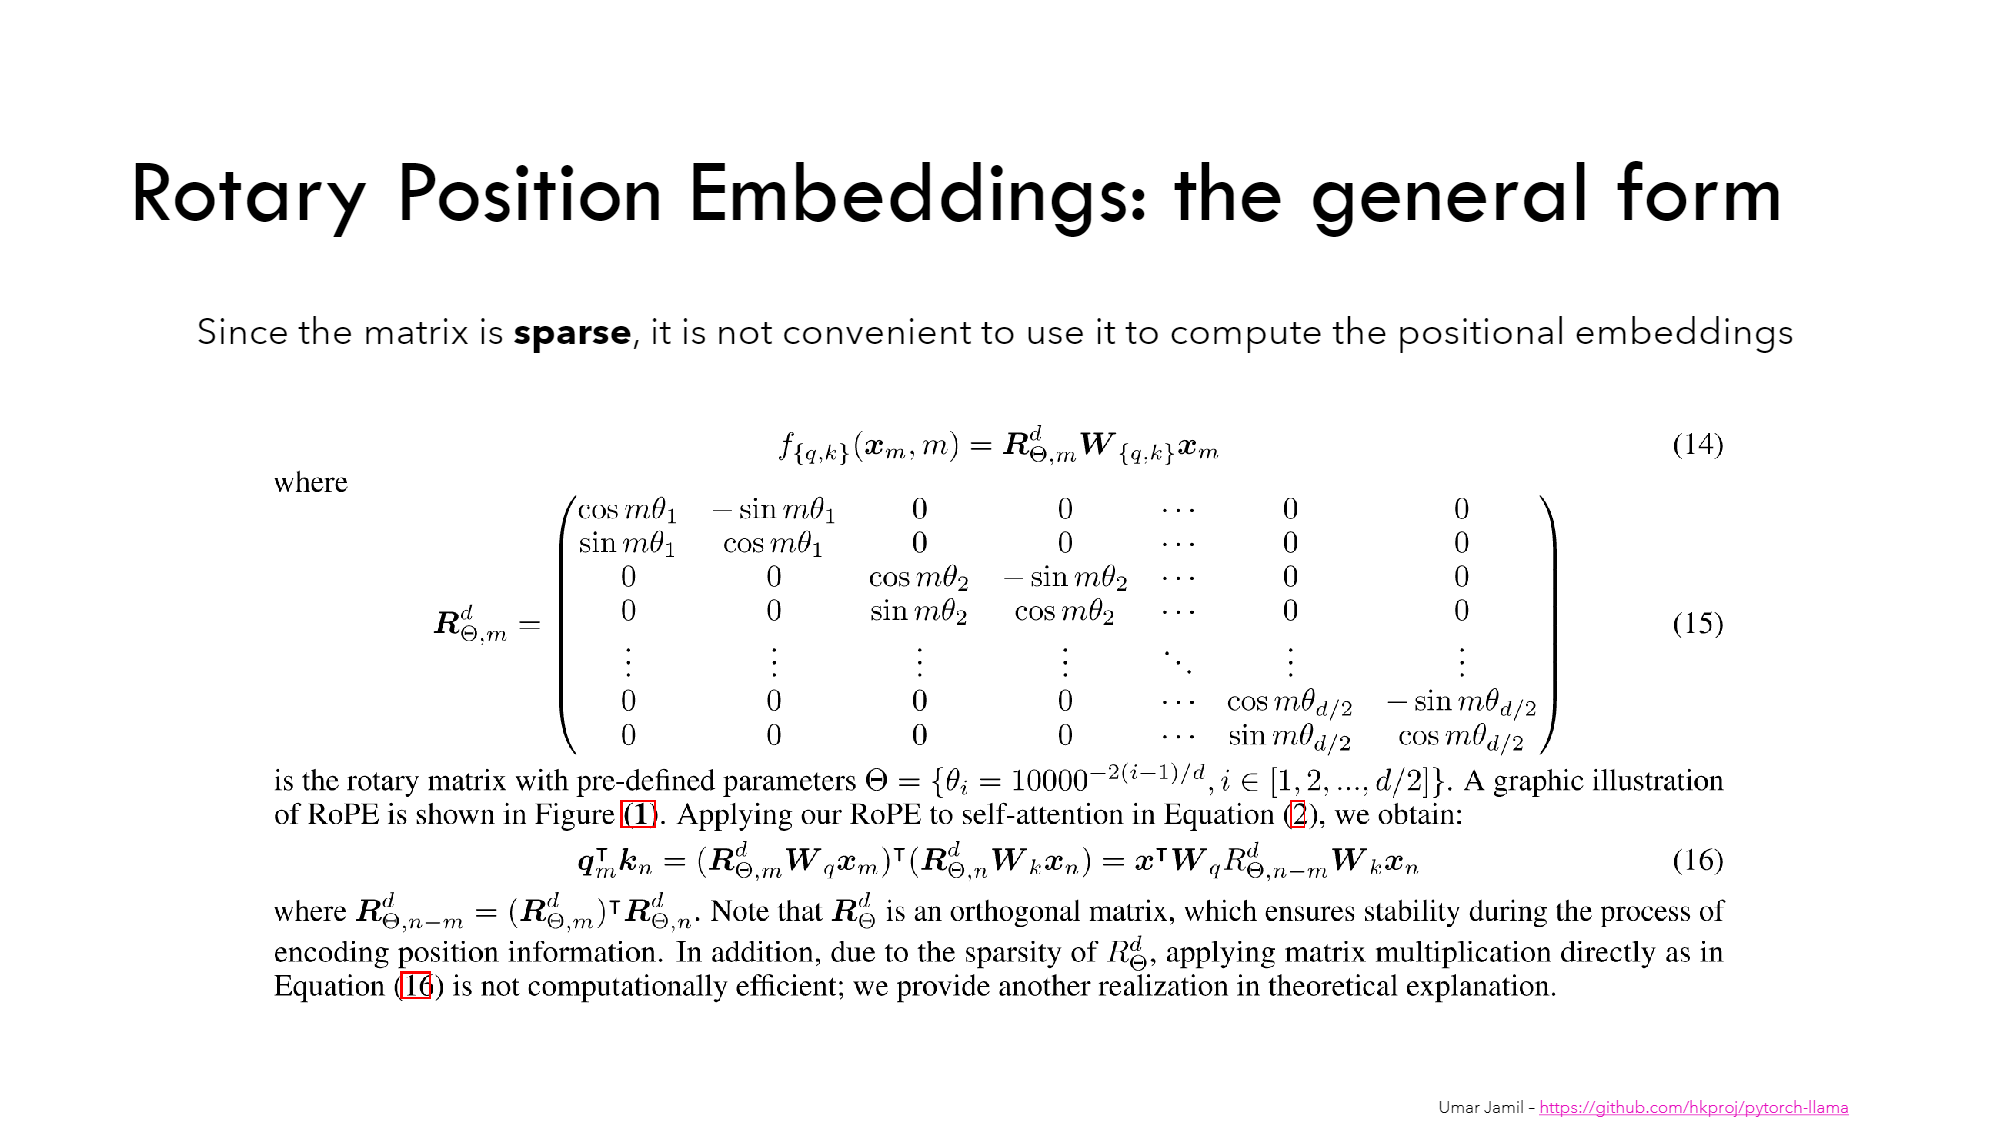
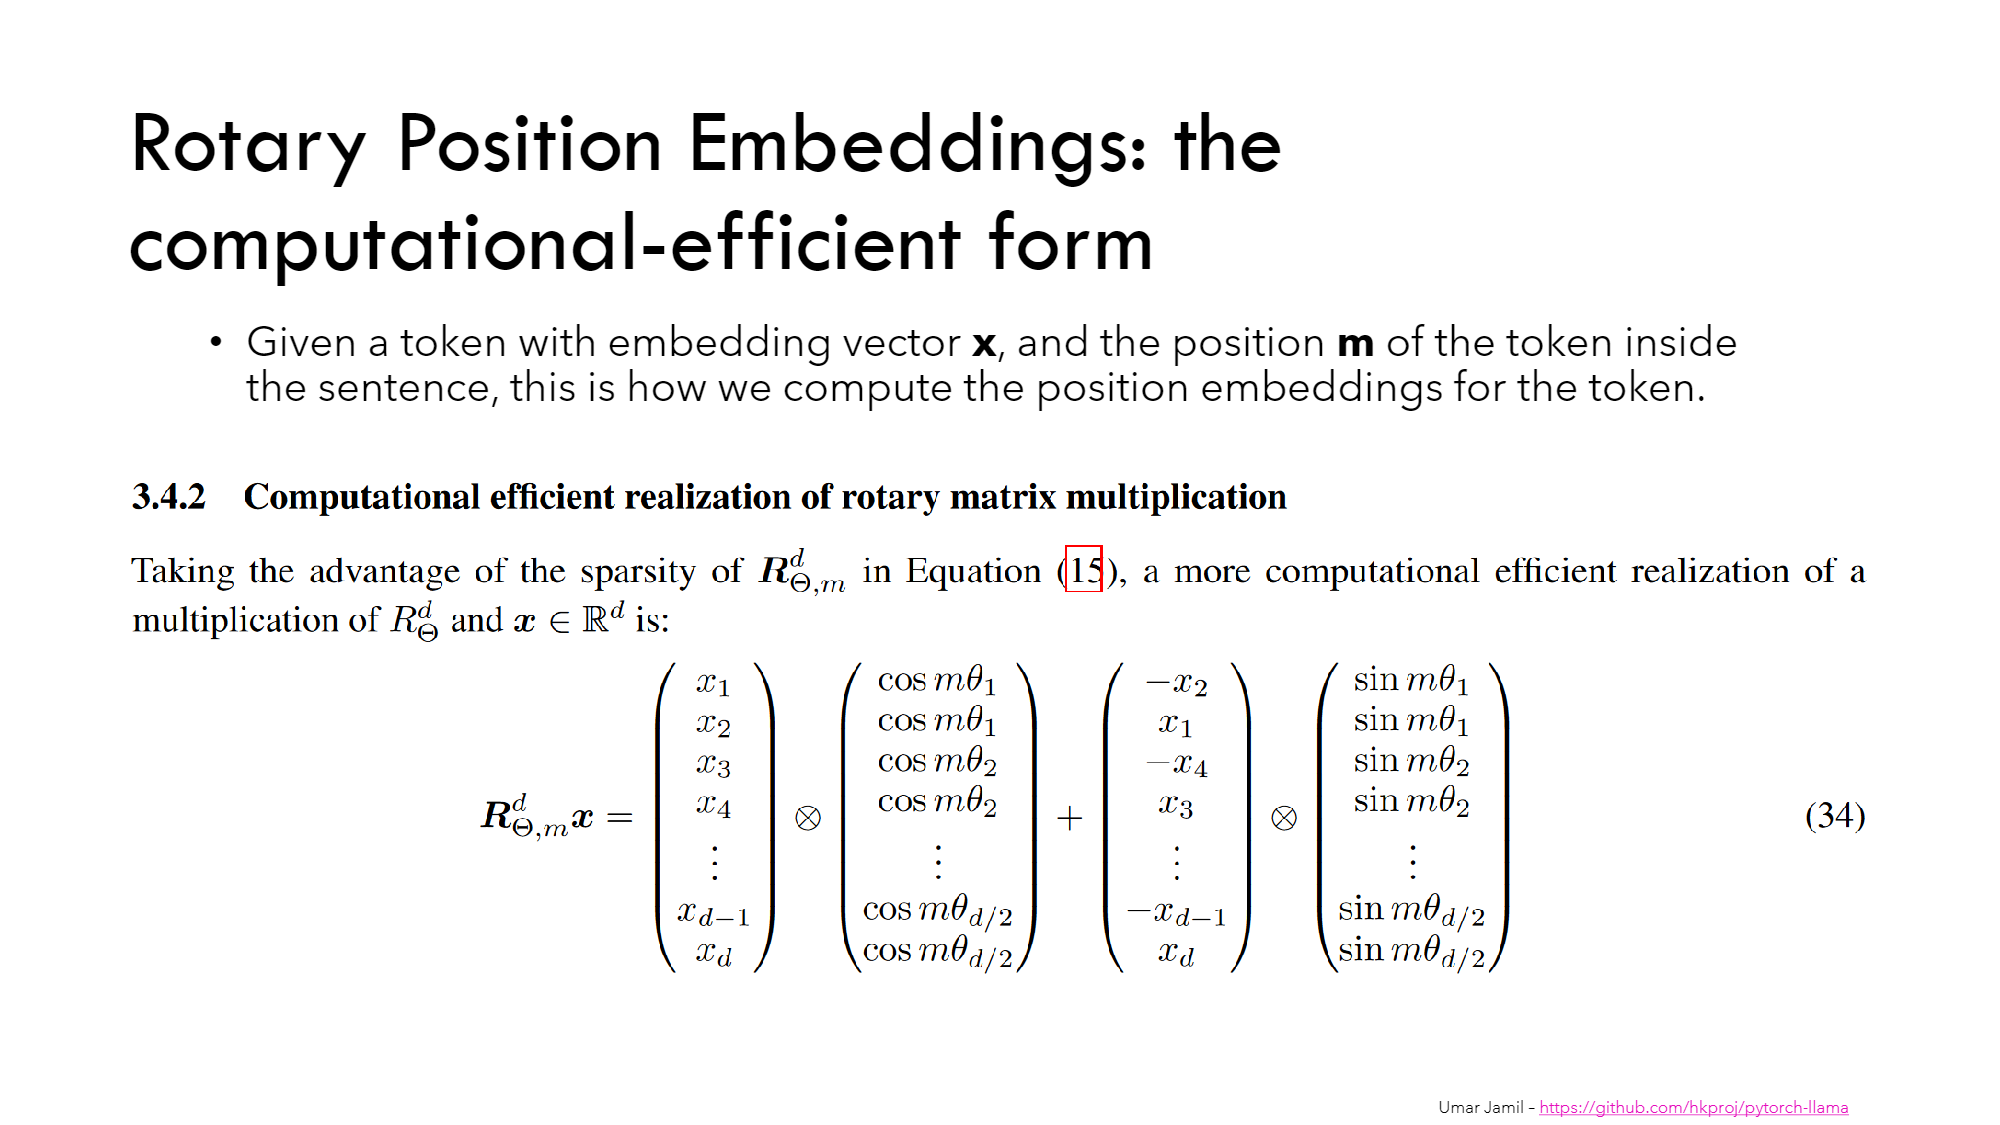


Source: Su, Jianlin, Yu Lu, Shengfeng Pan, Ahmed Murtadha, Bo Wen, and Yunfeng Liu. “RoFormer: Enhanced Transformer with Rotary Position Embedding,” November 8, 2023. https://doi.org/10.48550/arXiv.2104.09864.


In [ ]:
def precompute_theta_pos_frequencies(head_dim: int, seq_len: int, device: str, theta: float = 10000.0):
    # As written in the paragraph 3.2.2 of the paper
    # >> In order to generalize our results in 2D to any xi ∈ Rd where **d is even**, [...]
    assert head_dim % 2 == 0, "Dimension must be divisible by 2" # cannot be odd
    # Build the theta parameter
    # According to the formula theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
    # Shape: (Head_Dim / 2)
    theta_numerator = torch.arange(0, head_dim, 2).float()
    # Shape: (Head_Dim / 2)
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device) # (Dim / 2)
    # Construct the positions (the "m" parameter)
    # Shape: (Seq_Len)
    m = torch.arange(seq_len, device=device)
    # Multiply each theta by each position using the outer product.
    # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs = torch.outer(m, theta).float()
    # We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
    # (Seq_Len, Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

In [ ]:
def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor, device: str):
    # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
    # Two consecutive values will become a single complex number
    # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. So we need to add the batch dimension and the head dimension
    # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
    # Which results in the rotation of the complex number as shown in the Figure 1 of the paper
    # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
    x_rotated = x_complex * freqs_complex
    # Convert the complex number back to the real number
    # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)

In [ ]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch_size, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        # (B, Seq_Len, N_KV_Heads, 1, Head_Dim)
        x[:, :, :, None, :]
        # (B, Seq_Len, N_KV_Heads, N_Rep, Head_Dim)
        .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
        # (B, Seq_Len, N_KV_Heads * N_Rep, Head_Dim)
        .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
    )

## RMSNorm

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        # The gamma parameter
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x: torch.Tensor):
        # (B, Seq_Len, Dim) * (B, Seq_Len, 1) = (B, Seq_Len, Dim)
        # rsqrt: 1 / sqrt(x)
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x: torch.Tensor):
        # (Dim) * (B, Seq_Len, Dim) = (B, Seq_Len, Dim)
        return self.weight * self._norm(x.float()).type_as(x)

## SelfAttention

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()

        # Indicates the number of heads for the Keys and Values
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        # Indicates the number of heads for the Queries
        self.n_heads_q = args.n_heads
        # Indicates how many times the Keys and Values should be repeated
        self.n_rep = self.n_heads_q // self.n_kv_heads
        # Indicates the dimension of each head, that is, the part of the embedding that each head will be responsible for
        self.head_dim = args.dim // args.n_heads

        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)

        self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))
        self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_complex: torch.Tensor
    ):
        batch_size, seq_len, _ = x.shape  # (B, 1, Dim)

        # (B, 1, Dim) -> (B, 1, H_Q * Head_Dim)
        xq = self.wq(x)
        # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xk = self.wk(x)
        # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xv = self.wv(x)

        # (B, 1, H_Q * Head_Dim) -> (B, 1, H_Q, Head_Dim)
        xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim)
        # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)

        # (B, 1, H_Q, Head_Dim) --> (B, 1, H_Q, Head_Dim)
        xq = apply_rotary_embeddings(xq, freqs_complex, device=x.device)
        # (B, 1, H_KV, Head_Dim) --> (B, 1, H_KV, Head_Dim)
        xk = apply_rotary_embeddings(xk, freqs_complex, device=x.device)

        # Replace the entry in the cache
        self.cache_k[:batch_size, start_pos : start_pos + seq_len] = xk
        self.cache_v[:batch_size, start_pos : start_pos + seq_len] = xv

        # (B, Seq_Len_KV, H_KV, Head_Dim)
        keys = self.cache_k[:batch_size, : start_pos + seq_len]
        # (B, Seq_Len_KV, H_KV, Head_Dim)
        values = self.cache_v[:batch_size, : start_pos + seq_len]

        # Since every group of Q shares the same K and V heads, just repeat the K and V heads for every Q in the same group.

        # (B, Seq_Len_KV, H_KV, Head_Dim) --> (B, Seq_Len_KV, H_Q, Head_Dim)
        keys = repeat_kv(keys, self.n_rep)
        # (B, Seq_Len_KV, H_KV, Head_Dim) --> (B, Seq_Len_KV, H_Q, Head_Dim)
        values = repeat_kv(values, self.n_rep)

        # (B, 1, H_Q, Head_Dim) -> (B, H_Q, 1, Head_Dim)
        xq = xq.transpose(1, 2)
        # (B, Seq_Len_KV, H_Q, Head_Dim) -> (B, H_Q, Seq_Len_KV, Head_Dim)
        keys = keys.transpose(1, 2)
        # (B, Seq_Len_KV, H_Q, Head_Dim) -> (B, H_Q, Seq_Len_KV, Head_Dim)
        values = values.transpose(1, 2)

        # (B, H_Q, 1, Head_Dim) @ (B, H_Q, Head_Dim, Seq_Len_KV) -> (B, H_Q, 1, Seq_Len_KV)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        # (B, H_Q, 1, Seq_Len_KV) -> (B, H_Q, 1, Seq_Len_KV)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)

        # (B, H_Q, 1, Seq_Len) @ (B, H_Q, Seq_Len_KV, Head_Dim) -> (B, H_Q, 1, Head_Dim)
        output = torch.matmul(scores, values)
        # (B, H_Q, 1, Head_Dim) -> (B, 1, H_Q, Head_Dim) -> (B, 1, Dim)
        output = (output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1))
        return self.wo(output) # (B, 1, Dim) -> (B, 1, Dim)


## Feedforward

In [ ]:
class FeedForward(nn.Module):
    def __init__(
        self,
        args: ModelArgs
    ):
        super().__init__()

        hidden_dim = 4 * args.dim
        hidden_dim = int(2 * hidden_dim / 3)
        if args.ffn_dim_multiplier is not None:
            hidden_dim = int(args.ffn_dim_multiplier * hidden_dim)
        # Round the hidden_dim to the nearest multiple of the multiple_of parameter
        hidden_dim = args.multiple_of * ((hidden_dim + args.multiple_of - 1) // args.multiple_of)

        self.w1 = nn.Linear(args.dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, args.dim, bias=False)
        self.w3 = nn.Linear(args.dim, hidden_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        swish = F.silu(self.w1(x))
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        x_V = self.w3(x)
        # (B, Seq_Len, Hidden_Dim) * (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Hidden_Dim)
        x = swish * x_V
        # (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Dim)
        x = self.w2(x)
        return x

## Encoder Block

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, args: ModelArgs):
        super().__init__()

        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads

        self.attention = SelfAttention(args)
        self.feed_forward = FeedForward(args)

        # Normalization BEFORE the attention block
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        # Normalization BEFORE the feed forward block
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)
    
    def forward(self, x: torch.Tensor, start_pos: int, freqs_complex: torch.Tensor):
        # (B, Seq_Len, Dim) + (B, Seq_Len, Dim) --> (B, Seq_Len, Dim)
        h = x + self.attention.forward(
            self.attention_norm(x), start_pos, freqs_complex
        )
        # (B, Seq_Len, Dim) + (B, Seq_Len, Dim) --> (B, Seq_Len, Dim)
        out = h + self.feed_forward.forward(self.ffn_norm(h))
        return out

## Inference

In [ ]:
from typing import Optional
import torch
import time
from pathlib import Path
import json
from sentencepiece import SentencePieceProcessor
from tqdm import tqdm

from model import ModelArgs, Transformer

class LLaMA:

    def __init__(self, model: Transformer, tokenizer: SentencePieceProcessor, model_args: ModelArgs):
        self.model = model
        self.tokenizer = tokenizer
        self.args = model_args

    @staticmethod
    def build(checkpoints_dir: str, tokenizer_path: str, load_model: bool, max_seq_len: int, max_batch_size: int, device: str):
        prev_time = time.time()
        if load_model:
            checkpoints = sorted(Path(checkpoints_dir).glob("*.pth"))
            assert len(checkpoints) > 0, f"no checkpoint files found in {checkpoints_dir}"
            ckpt_path = checkpoints[0]
            print(f'Loading checkpoint "{ckpt_path}"')
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            print(f"Loaded checkpoint in {time.time() - prev_time:.2f}s")
            prev_time = time.time()
        with open(Path(checkpoints_dir) / "params.json", "r") as f:
            params = json.loads(f.read())

        model_args: ModelArgs = ModelArgs(
            max_seq_len=max_seq_len,
            max_batch_size=max_batch_size,
            device=device,
            **params
        )

        tokenizer = SentencePieceProcessor()
        tokenizer.load(tokenizer_path)
        model_args.vocab_size = tokenizer.vocab_size()
        
        if device == "cuda":
            torch.set_default_tensor_type(torch.cuda.HalfTensor)
        else:
            torch.set_default_tensor_type(torch.BFloat16Tensor)
        
        model = Transformer(model_args).to(device)

        if load_model:
            # The only unmatched key in the checkpoint is rope.freqs. Remove it
            del checkpoint['rope.freqs']
            model.load_state_dict(checkpoint, strict=True)
            print(f"Loaded state dict in {time.time() - prev_time:.2f}s")
        
        return LLaMA(model, tokenizer, model_args)

    def text_completion(self, prompts: list[str], temperature: float = 0.6, top_p: float = 0.9, max_gen_len: Optional[int] = None):
        if max_gen_len is None:
            max_gen_len = self.args.max_seq_len - 1
        # Convert each prompt into tokens
        prompt_tokens = [self.tokenizer.encode(prompt, out_type=int, add_bos=True, add_eos=False) for prompt in prompts]
        # Make sure the batch size is not too large
        batch_size = len(prompt_tokens)
        assert batch_size <= self.args.max_batch_size, f"batch size must be less than or equal to {self.args.max_batch_size}"
        max_prompt_len = max(len(prompt) for prompt in prompt_tokens)
        # Make sure the prompt length is not larger than the maximum sequence length
        assert max_prompt_len <= self.args.max_seq_len, f"prompt length must be less than or equal to {self.args.max_seq_len}"
        total_len = min(self.args.max_seq_len, max_gen_len + max_prompt_len)

        # Create the list that will contain the generated tokens, along with the initial prompt tokens
        pad_id = self.tokenizer.pad_id()
        tokens = torch.full((batch_size, total_len), pad_id, dtype=torch.long, device=device)
        for k, t in enumerate(prompt_tokens):
            # Populate the initial tokens with the prompt tokens
            tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device=device)
        
        eos_reached = torch.tensor([False] * batch_size, device=device)
        prompt_tokens_mask = tokens != pad_id # True if the token is a prompt token, False otherwise
        cur_iterator = tqdm(range(1, total_len), desc="Generating tokens")
        for cur_pos in cur_iterator:
            with torch.no_grad():
                logits = self.model.forward(tokens[:, cur_pos-1:cur_pos], cur_pos)
            if temperature > 0:
                # The temperature is applied before the softmax
                probs = torch.softmax(logits[:, -1] / temperature, dim=-1)
                next_token = self._sample_top_p(probs, top_p)
            else:
                # Greedily select the token with the max probability
                next_token = torch.argmax(logits[:, -1], dim=-1)

            next_token = next_token.reshape(-1)
            # Only replace token if it is a padding token
            next_token = torch.where(prompt_tokens_mask[:, cur_pos], tokens[:, cur_pos], next_token)
            tokens[:, cur_pos] = next_token
            # EOS is reached only if we found an EOS token for a padding position
            eos_reached |= (~prompt_tokens_mask[:, cur_pos]) & (next_token == self.tokenizer.eos_id)
            if all(eos_reached):
                break

        out_tokens = []
        out_text = []
        for prompt_index, current_prompt_tokens in enumerate(tokens.tolist()):
            # Cut to the EOS token, if present
            if self.tokenizer.eos_id in current_prompt_tokens:
                eos_idx = current_prompt_tokens.index(self.tokenizer.eos_id)
                current_prompt_tokens = current_prompt_tokens[:eos_idx]
            out_tokens.append(current_prompt_tokens)
            out_text.append(self.tokenizer.decode(current_prompt_tokens))
        return (out_tokens, out_text)
    
    def _sample_top_p(self, probs, p):
        # (B, vocab_size)
        probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
        # (B, vocab_size)
        probs_sum = torch.cumsum(probs_sort, dim=-1)
        # (B, vocab_size)
        # (Substracting "probs_sort" shifts the cumulative sum by 1 position to the right before masking)
        mask = probs_sum - probs_sort > p 
        # Zero out all the probabilities of tokens that are not selected by the Top P
        probs_sort[mask] = 0.0 
        # Redistribute the probabilities so that they sum up to 1.
        probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
        # Sample a token (its index) from the top p distribution
        next_token = torch.multinomial(probs_sort, num_samples=1)
        # Get the token position in the vocabulary corresponding to the sampled index
        next_token = torch.gather(probs_idx, -1, next_token) 
        return next_token



if __name__ == '__main__':
    torch.manual_seed(0)

    allow_cuda = False
    device = 'cuda' if torch.cuda.is_available() and allow_cuda else 'cpu'

    prompts = [
        "Simply put, the theory of relativity states that ",
        "If Google was an Italian company founded in Milan, it would",
        # Few shot promt
        """Translate English to French:
        
        sea otter => loutre de mer
        peppermint => menthe poivrée
        plush girafe => girafe peluche
        cheese =>""",
        # Zero shot prompt
        """Tell me if the following person is actually Doraemon disguised as human:
        Name: Umar Jamil
        Decision: 
        """
    ]

    model = LLaMA.build(
        checkpoints_dir='llama-2-7b/',
        tokenizer_path='tokenizer.model',
        load_model=True,
        max_seq_len=1024,
        max_batch_size=len(prompts),
        device=device
    )

    out_tokens, out_texts = (model.text_completion(prompts, max_gen_len=64))
    assert len(out_texts) == len(prompts)
    for i in range(len(out_texts)):
        print(f'{out_texts[i]}')
        print('-' * 50)